In [2]:
import open3d as o3d
import numpy as np
import pandas as pd
import os
import re
from glob import glob
import time
import random
import seaborn as sns
import xml.etree.ElementTree as ET
from mpl_toolkits.mplot3d import Axes3D
from pyntcloud import PyntCloud
import plotly.graph_objs as go
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt 
from plotly.offline import iplot, init_notebook_mode

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import MulticlassMatthewsCorrCoef
import torch.optim as optim


import warnings
warnings.filterwarnings("ignore")

init_notebook_mode(connected=True)
%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

category_mapping = {
    0: [7, 22, 9, 26, 11, 21, 51, 50, 5, 18, 23, 3, 24, 31, 2],  # Drivable (Road, Drivable Vegetation, Terrain)
    1: [43, 38, 58, 29, 41, 42, 44, 39, 55,  # Construction
        4, 45, 6, 40, 60, 61, 33, 32, 14,   # Object
        48, 47, 1, 19, 46, 10, 25,         # Sign
        28, 27, 62, 52, 16, 30, 59, 17,    # Non Drivable Vegetation
        13, 15, 12, 36, 57, 49, 20, 35, 37, 34, 63],  # Vehicle
    2: [8, 56, 0, 53, 54],  # Void
}

# Generar el diccionario inverso para mapear etiquetas
label_to_category = {label: cat for cat, labels in category_mapping.items() for label in labels}

# Función para remapear etiquetas
def map_labels(labels: np.ndarray) -> np.ndarray:
    return np.array([label_to_category.get(label, 2) for label in labels], dtype=np.uint8)

def load_bin_file(bin_path: str, radius: float = 25.0):
    """ Carga la nube de puntos y mantiene los índices originales tras el filtrado """
    points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)[:, :3]
    distances = np.linalg.norm(points, axis=1)
    mask = distances <= radius
    return points[mask], np.where(mask)[0]  # Devolver puntos filtrados y sus índices originales

def load_label_file(label_path: str, indices: np.ndarray) -> np.ndarray:
    """ Carga etiquetas utilizando los índices originales y las mapea a categorías. """
    labels = np.fromfile(label_path, dtype=np.uint32) & 0xFFFF
    return map_labels(labels[indices])  # Extrae etiquetas correctas según índices originales

def normalize_point_cloud(points):
    """ Normaliza la nube restando la media y dividiendo por la desviación estándar. """
    mean = np.mean(points, axis=0)
    std = np.std(points, axis=0) + 1e-6
    return (points - mean) / std

def divide_into_subnubes(points, labels, original_indices, num_points=16384):
    """ Divide la nube en subnubes de tamaño fijo. Si no se puede dividir al menos una vez, se descarta. """
    num_total = points.shape[0]

    # Si la nube tiene menos de num_points, se descarta completamente
    if num_total < num_points:
        print(f" Descartando nube con {num_total} puntos (menor a {num_points})")
        return []

    # Ajustar a un múltiplo exacto de num_points
    num_valid = num_total - (num_total % num_points)

    # Si después del ajuste sigue sin haber al menos una subnube completa, se descarta
    if num_valid < num_points:
        print(f" Descartando nube con {num_valid} puntos (no alcanza {num_points} tras ajuste)")
        return []

    # Dividir en subnubes exactas
    subnubes = [
        (points[i * num_points: (i + 1) * num_points],
         labels[i * num_points: (i + 1) * num_points],
         original_indices[i * num_points: (i + 1) * num_points])  
        for i in range(num_valid // num_points)
    ]
    
    return subnubes

class GOOSEDataset(Dataset):
    def __init__(self, x_path, y_path, num_points=4096):
        self.x_files = sorted([os.path.join(x_path, f) for f in os.listdir(x_path) if f.endswith(".bin")])
        self.y_files = sorted([os.path.join(y_path, f) for f in os.listdir(y_path) if f.endswith(".label")])
        assert len(self.x_files) == len(self.y_files), "Número de archivos de entrada y etiquetas no coinciden"
        
        self.num_points = num_points
        self.subnubes = []  # Almacenar todas las subnubes generadas
        
        # Cargar y dividir todas las nubes en subnubes con tqdm
        for x_file, y_file in tqdm(zip(self.x_files, self.y_files), total=len(self.x_files), desc="Procesando nubes de puntos"):
            points, indices = load_bin_file(x_file)  # Obtener puntos e índices originales tras filtrado
            labels = load_label_file(y_file, indices)  # Obtener etiquetas con los índices filtrados

            points = normalize_point_cloud(points)  # Normalizar nube
            subnubes = divide_into_subnubes(points, labels, indices, num_points)  # Mantener relación de índices
            
            self.subnubes.extend(subnubes)  # Guardar subnubes en lista global

    def __len__(self):
        return len(self.subnubes)  # Devuelve el total de subnubes en el dataset

    def __getitem__(self, idx):
        points, labels, original_indices = self.subnubes[idx]
        return torch.tensor(points, dtype=torch.float32), torch.tensor(labels, dtype=torch.long)

In [4]:
x_train_path = "/home/fmartinez/datasets/lidar/train"
y_train_path = "/home/fmartinez/datasets/labels/train"
x_val_path = "/home/fmartinez/datasets_val/lidar/val"
y_val_path = "/home/fmartinez/datasets_val/labels/val"

In [5]:
train_dataset = GOOSEDataset(x_train_path, y_train_path, num_points=16384)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

Procesando nubes de puntos:  53%|█████▎    | 4109/7719 [14:35<04:21, 13.80it/s]

 Descartando nube con 11446 puntos (menor a 16384)
 Descartando nube con 9017 puntos (menor a 16384)


Procesando nubes de puntos:  54%|█████▎    | 4137/7719 [14:39<04:28, 13.32it/s]

 Descartando nube con 16196 puntos (menor a 16384)


Procesando nubes de puntos:  64%|██████▍   | 4940/7719 [17:12<03:41, 12.55it/s]

 Descartando nube con 15598 puntos (menor a 16384)
 Descartando nube con 9878 puntos (menor a 16384)


Procesando nubes de puntos:  82%|████████▏ | 6324/7719 [21:08<01:52, 12.35it/s]

 Descartando nube con 10343 puntos (menor a 16384)


Procesando nubes de puntos:  92%|█████████▏| 7094/7719 [23:18<00:57, 10.94it/s]

 Descartando nube con 13772 puntos (menor a 16384)


Procesando nubes de puntos:  92%|█████████▏| 7104/7719 [23:19<00:56, 10.79it/s]

 Descartando nube con 16176 puntos (menor a 16384)


Procesando nubes de puntos:  93%|█████████▎| 7164/7719 [23:29<01:13,  7.59it/s]

 Descartando nube con 11447 puntos (menor a 16384)


Procesando nubes de puntos:  94%|█████████▍| 7269/7719 [23:42<00:34, 13.23it/s]

 Descartando nube con 13570 puntos (menor a 16384)


Procesando nubes de puntos: 100%|██████████| 7719/7719 [25:07<00:00,  5.12it/s]


In [6]:
val_dataset = GOOSEDataset(x_val_path, y_val_path, num_points=16384)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

Procesando nubes de puntos:  55%|█████▌    | 531/961 [01:34<00:25, 16.86it/s]

 Descartando nube con 14147 puntos (menor a 16384)
 Descartando nube con 14449 puntos (menor a 16384)


Procesando nubes de puntos:  56%|█████▌    | 537/961 [01:34<00:20, 21.04it/s]

 Descartando nube con 10055 puntos (menor a 16384)


Procesando nubes de puntos:  95%|█████████▌| 914/961 [02:43<00:03, 13.46it/s]

 Descartando nube con 13018 puntos (menor a 16384)
 Descartando nube con 14846 puntos (menor a 16384)


Procesando nubes de puntos: 100%|██████████| 961/961 [02:49<00:00,  5.67it/s]


In [24]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [25]:
for subnube in train_dataset:
    points, labels = subnube
    assert points.shape[0] == 16384, f"ERROR: Subnube de tamaño {points.shape[0]} en vez de 16384"
    assert labels.shape[0] == 16384, f"ERROR: Etiquetas de tamaño {labels.shape[0]} en vez de 16384"

In [26]:
import plotly.graph_objects as go
import pandas as pd

def plot_3D_colors(sampled_df):
    # Define color map and categories
    color_map = {
        0: 'purple',
        1: 'black',
        2: 'cyan',
        3: 'darkgreen',
        4: 'blue',
        5: 'limegreen',
        6: 'green',
        7: 'orange',
        8: 'red'
    }

    label_categories = [
        'Construction', 'Object', 'Road', 'Sign', 'Terrain',
        'Drivable Vegetation', 'Non Drivable Vegetation', 'Vehicle', 'Void'
    ]

    # Map label colors using apply to avoid NaN issues
    scatter_colors = sampled_df['label'].apply(lambda x: color_map.get(x, 'gray'))
    scatter_texts = sampled_df['label'].apply(lambda x: label_categories[x])  #  Nombre de la clase

    # Create a 3D scatter plot without adding it to the legend
    fig = go.Figure()

    fig.add_trace(go.Scatter3d(
        x=sampled_df['x'],
        y=sampled_df['y'],
        z=sampled_df['z'],
        mode='markers',
        marker=dict(
            size=2,  # Ajustar tamaño del punto
            color=scatter_colors,  # Color por categoría
            opacity=0.7  # Ajustar opacidad
        ),
        text=scatter_texts,  #  Se muestra el nombre de la clase al pasar el mouse
        hoverinfo="text",  #  Muestra solo el texto en hover
        showlegend=False  # Evita que los puntos aparezcan en la leyenda
    ))

    # Add legend manually
    for label, color in color_map.items():
        fig.add_trace(go.Scatter(
            x=[None], y=[None], mode='markers',
            marker=dict(size=10, color=color),
            name=label_categories[label],
            showlegend=True  # 🔹 Solo estos elementos aparecen en la leyenda
        ))

    # Set labels and title
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        title='3D Point Cloud with Label Colors',
        legend_title='Labels'
    )

    fig.show()

In [27]:
# Extract a batch from the train_loader
batch = next(iter(val_loader))

# Separate the point cloud data and labels
point_cloud_batch, labels_batch = batch

# Select the first sample in the batch (index 0)
sample_point_cloud = point_cloud_batch[0].numpy()
sample_labels = labels_batch[0].numpy()

In [28]:
# Convert the point cloud sample to a DataFrame
sampled_df = pd.DataFrame(sample_point_cloud, columns=['x', 'y', 'z'])
sampled_df['label'] = sample_labels
sampled_df.head()

,x,y,z,label
0,-0.200344,-0.743490,0.099730,2
1,-0.713623,-0.813805,-1.422403,0
2,-0.874346,-0.834629,-1.451085,0
3,-1.043247,-0.851269,-1.487270,0
4,-1.220980,-0.893535,-1.533787,0


In [29]:
plot_3D_colors(sampled_df)

In [ ]:
class Tnet(nn.Module):
    ''' T-Net learns a Transformation matrix with a specified dimension '''
    def __init__(self, dim, num_points=16384):
        super(Tnet, self).__init__()

        # dimensions for transform matrix
        self.dim = dim 

        self.conv1 = nn.Conv1d(dim, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv3 = nn.Conv1d(128, 1024, kernel_size=1)

        self.linear1 = nn.Linear(1024, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, dim**2)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.max_pool = nn.MaxPool1d(kernel_size=num_points)
        

    def forward(self, x):
        bs = x.shape[0]

        # pass through shared MLP layers (conv1d)
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))

        # max pool over num points
        x = self.max_pool(x).view(bs, -1)
        
        # pass through MLP
        x = self.bn4(F.relu(self.linear1(x)))
        x = self.bn5(F.relu(self.linear2(x)))
        x = self.linear3(x)

        # initialize identity matrix
        iden = torch.eye(self.dim, requires_grad=True).repeat(bs, 1, 1)
        if x.is_cuda:
            iden = iden.cuda()

        x = x.view(-1, self.dim, self.dim) + iden

        return x


class PointNetBackbone(nn.Module):

    def __init__(self, num_points=16384, num_global_feats=1024, local_feat=True):
        ''' Initializers:
                num_points - number of points in point cloud
                num_global_feats - number of Global Features for the main 
                                   Max Pooling layer
                local_feat - if True, forward() returns the concatenation 
                             of the local and global features
            '''
        super(PointNetBackbone, self).__init__()

        # if true concat local and global features
        self.num_points = num_points
        self.num_global_feats = num_global_feats
        self.local_feat = local_feat

        # Spatial Transformer Networks (T-nets)
        self.tnet1 = Tnet(dim=3, num_points=num_points)
        self.tnet2 = Tnet(dim=64, num_points=num_points)

        # shared MLP 1
        self.conv1 = nn.Conv1d(3, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=1)

        # shared MLP 2
        self.conv3 = nn.Conv1d(64, 64, kernel_size=1)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv5 = nn.Conv1d(128, self.num_global_feats, kernel_size=1)
        
        # batch norms for both shared MLPs
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(self.num_global_feats)

        # max pool to get the global features
        self.max_pool = nn.MaxPool1d(kernel_size=num_points, return_indices=True)

    
    def forward(self, x):

        # get batch size
        bs = x.shape[0]
        
        # pass through first Tnet to get transform matrix
        A_input = self.tnet1(x)

        # perform first transformation across each point in the batch
        x = torch.bmm(x.transpose(2, 1), A_input).transpose(2, 1)

        # pass through first shared MLP
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        
        # get feature transform
        A_feat = self.tnet2(x)

        # perform second transformation across each (64 dim) feature in the batch
        x = torch.bmm(x.transpose(2, 1), A_feat).transpose(2, 1)

        # store local point features for segmentation head
        local_features = x.clone()

        # pass through second MLP
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)))

        # get global feature vector and critical indexes
        global_features, critical_indexes = self.max_pool(x)
        global_features = global_features.view(bs, -1)
        critical_indexes = critical_indexes.view(bs, -1)

        if self.local_feat:
            features = torch.cat((local_features, 
                                  global_features.unsqueeze(-1).repeat(1, 1, self.num_points)), 
                                  dim=1)

            return features, critical_indexes, A_feat

        else:
            return global_features, critical_indexes, A_feat


class PointNetSegHead(nn.Module):
    ''' Segmentation Head '''
    def __init__(self, num_points=4096, num_global_feats=1024, m=2):
        super(PointNetSegHead, self).__init__()

        self.num_points = num_points
        self.m = m

        # get the backbone 
        self.backbone = PointNetBackbone(num_points, num_global_feats, local_feat=True)

        # shared MLP
        num_features = num_global_feats + 64 # local and global features
        self.conv1 = nn.Conv1d(num_features, 512, kernel_size=1)
        self.conv2 = nn.Conv1d(512, 256, kernel_size=1)
        self.conv3 = nn.Conv1d(256, 128, kernel_size=1)
        self.conv4 = nn.Conv1d(128, m, kernel_size=1)

        # batch norms for shared MLP
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)


    def forward(self, x):
        
        # get combined features
        x, crit_idxs, A_feat = self.backbone(x) 

        # pass through shared MLP
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.conv4(x)

        x = x.transpose(2, 1)
        
        return x, crit_idxs, A_feat

In [31]:
seg_model = PointNetSegHead(num_points=16384, m=3)
points, targets = next(iter(train_loader))
out, _, _ = seg_model(points.transpose(2, 1))
print(f'Seg shape: {out.shape}')

Seg shape: torch.Size([8, 16384, 3])


## Función de coste

In [32]:
# special loss for segmentation Focal Loss + Dice Loss
class PointNetSegLoss(nn.Module):
    def __init__(self, alpha=None, gamma=0, size_average=True, dice=False):
        super(PointNetSegLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.size_average = size_average
        self.dice = dice

        # sanitize inputs
        if isinstance(alpha,(float, int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,(list, np.ndarray)): self.alpha = torch.Tensor(alpha)

        # get Balanced Cross Entropy Loss
        self.cross_entropy_loss = nn.CrossEntropyLoss(weight=self.alpha)
        

    def forward(self, predictions, targets, pred_choice=None):

        # get Balanced Cross Entropy Loss
        ce_loss = self.cross_entropy_loss(predictions.transpose(2, 1), targets)

        # reformat predictions (b, n, c) -> (b*n, c)
        predictions = predictions.contiguous() \
                                 .view(-1, predictions.size(2)) 
        # get predicted class probabilities for the true class
        pn = F.softmax(predictions)
        pn = pn.gather(1, targets.view(-1, 1)).view(-1)

        # compute loss (negative sign is included in ce_loss)
        loss = ((1 - pn)**self.gamma * ce_loss)
        if self.size_average: loss = loss.mean() 
        else: loss = loss.sum()

        # add dice coefficient if necessary
        if self.dice: return loss + self.dice_loss(targets, pred_choice, eps=1)
        else: return loss


    @staticmethod
    def dice_loss(predictions, targets, eps=1):
        ''' Compute Dice loss, directly compare predictions with truth '''

        targets = targets.reshape(-1)
        predictions = predictions.reshape(-1)

        cats = torch.unique(targets)

        top = 0
        bot = 0
        for c in cats:
            locs = targets == c

            # get truth and predictions for each class
            y_tru = targets[locs]
            y_hat = predictions[locs]

            top += torch.sum(y_hat == y_tru)
            bot += len(y_tru) + len(y_hat)


        return 1 - 2*((top + eps)/(bot + eps)) 

## Entrenamiento

In [35]:
# Training hyperparameters

EPOCHS = 3
LR = 0.0001
BATCH_SIZE = 8
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)


# manually set alpha weights
alpha = np.ones(3)
alpha[0] *= 0.6
alpha[1] *= 0.4


gamma = 1

optimizer = optim.Adam(seg_model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-6, max_lr=1e-4, 
                                              step_size_up=1000, cycle_momentum=False)
criterion = PointNetSegLoss(alpha=alpha, gamma=gamma, dice=True).to(DEVICE)

seg_model = seg_model.to(DEVICE)

cuda


In [36]:
mcc_metric = MulticlassMatthewsCorrCoef(num_classes=3).to(DEVICE)

In [37]:
# We also want to track how well the models learns structure, so we will keep track of the IOU

def compute_iou(targets, predictions):

    targets = targets.reshape(-1)
    predictions = predictions.reshape(-1)

    intersection = torch.sum(predictions == targets) # true positives
    union = len(predictions) + len(targets) - intersection

    return intersection / union 

In [38]:
# store best validation iou
best_iou = 0.7
best_mcc = 0.7

# lists to store metrics
train_loss = []
train_accuracy = []
train_mcc = []
train_iou = []
valid_loss = []
valid_accuracy = []
valid_mcc = []
valid_iou = []

In [39]:
import gc

gc.collect()  # Limpia memoria en CPU
torch.cuda.empty_cache()  # Libera memoria en GPU
torch.cuda.ipc_collect()  # Fuerza la recolección de memoria compartida

In [41]:
NUM_TRAIN_POINTS = train_dataset.num_points  # Se ajusta dinámicamente según el dataset
BATCH_SIZE = 8

# Calcular número de batches
num_train_batch = int(np.ceil(len(train_dataset) / BATCH_SIZE))
num_valid_batch = int(np.ceil(len(val_dataset) / BATCH_SIZE))

for epoch in range(1, EPOCHS + 1):
    seg_model.train()
    
    _train_loss = []
    _train_accuracy = []
    _train_mcc = []
    _train_iou = []

    for i, (points, targets) in enumerate(train_loader, 0):
        points = points.transpose(2, 1).to(DEVICE)
        targets = targets.to(DEVICE)

        optimizer.zero_grad()
        
        # Forward pass
        preds, _, _ = seg_model(points)
        pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)

        # Cálculo de pérdida
        loss = criterion(preds, targets, pred_choice)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Cálculo de métricas
        correct = pred_choice.eq(targets.data).cpu().sum()
        total_points = targets.numel()  # Número total de puntos en el batch
        accuracy = correct / float(total_points)

        mcc = mcc_metric(preds.transpose(2, 1), targets)
        iou = compute_iou(targets, pred_choice)

        # Guardar métricas
        _train_loss.append(loss.item())
        _train_accuracy.append(accuracy.item())  
        _train_mcc.append(mcc.item())
        _train_iou.append(iou.item())

        if i % 500 == 0:
            print(f'\t [{epoch}: {i}/{num_train_batch}] ' \
                  + f'train loss: {loss.item():.4f} ' \
                  + f'accuracy: {accuracy:.4f} ' \
                  + f'mcc: {mcc:.4f} ' \
                  + f'iou: {iou:.4f}')
        
    train_loss.append(np.mean(_train_loss))
    train_accuracy.append(np.mean(_train_accuracy))
    train_mcc.append(np.mean(_train_mcc))
    train_iou.append(np.mean(_train_iou))

    print(f'Epoch: {epoch} - Train Loss: {train_loss[-1]:.4f} ' \
          + f'- Train Accuracy: {train_accuracy[-1]:.4f} ' \
          + f'- Train MCC: {train_mcc[-1]:.4f} ' \
          + f'- Train IOU: {train_iou[-1]:.4f}')

    # Enfriamiento
    time.sleep(4)

    # **Validación**
    with torch.no_grad():
        seg_model.eval()

        _valid_loss = []
        _valid_accuracy = []
        _valid_mcc = []
        _valid_iou = []

        for i, (points, targets) in enumerate(val_loader, 0):
            points = points.transpose(2, 1).to(DEVICE)
            targets = targets.to(DEVICE)

            preds, _, A = seg_model(points)
            pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)

            loss = criterion(preds, targets, pred_choice)

            # Cálculo de métricas
            correct = pred_choice.eq(targets.data).cpu().sum()
            total_points = targets.numel()
            accuracy = correct / float(total_points)

            mcc = mcc_metric(preds.transpose(2, 1), targets)
            iou = compute_iou(targets, pred_choice)

            # Guardar métricas
            _valid_loss.append(loss.item())
            _valid_accuracy.append(accuracy.item())
            _valid_mcc.append(mcc.item())
            _valid_iou.append(iou.item())

            if i % 500 == 0:
                print(f'\t [{epoch}: {i}/{num_valid_batch}] ' \
                      + f'valid loss: {loss.item():.4f} ' \
                      + f'accuracy: {accuracy:.4f} '
                      + f'mcc: {mcc:.4f} ' \
                      + f'iou: {iou:.4f}')
        
        valid_loss.append(np.mean(_valid_loss))
        valid_accuracy.append(np.mean(_valid_accuracy))
        valid_mcc.append(np.mean(_valid_mcc))
        valid_iou.append(np.mean(_valid_iou))

        print(f'Epoch: {epoch} - Valid Loss: {valid_loss[-1]:.4f} ' \
              + f'- Valid Accuracy: {valid_accuracy[-1]:.4f} ' \
              + f'- Valid MCC: {valid_mcc[-1]:.4f} ' \
              + f'- Valid IOU: {valid_iou[-1]:.4f}')

        # Enfriamiento
        time.sleep(4)

	 [1: 0/7030] train loss: 1.1620 accuracy: 0.4902 mcc: 0.2587 iou: 0.3247
	 [1: 500/7030] train loss: 1.0540 accuracy: 0.5879 mcc: 0.2619 iou: 0.4164
	 [1: 1000/7030] train loss: 0.5616 accuracy: 0.7939 mcc: 0.4679 iou: 0.6583
	 [1: 1500/7030] train loss: 0.3665 accuracy: 0.7991 mcc: 0.5443 iou: 0.6655
	 [1: 2000/7030] train loss: 0.4243 accuracy: 0.7998 mcc: 0.4765 iou: 0.6663
	 [1: 2500/7030] train loss: 0.4349 accuracy: 0.7885 mcc: 0.4499 iou: 0.6509
	 [1: 3000/7030] train loss: 0.3651 accuracy: 0.8048 mcc: 0.6341 iou: 0.6733
	 [1: 3500/7030] train loss: 0.4098 accuracy: 0.7947 mcc: 0.4697 iou: 0.6593
	 [1: 4000/7030] train loss: 0.5342 accuracy: 0.7227 mcc: 0.4662 iou: 0.5658
	 [1: 4500/7030] train loss: 0.4933 accuracy: 0.7413 mcc: 0.4156 iou: 0.5890
	 [1: 5000/7030] train loss: 0.3916 accuracy: 0.7739 mcc: 0.4336 iou: 0.6312
	 [1: 5500/7030] train loss: 0.4138 accuracy: 0.7594 mcc: 0.4608 iou: 0.6121
	 [1: 6000/7030] train loss: 0.2869 accuracy: 0.8375 mcc: 0.6933 iou: 0.7204
	 [

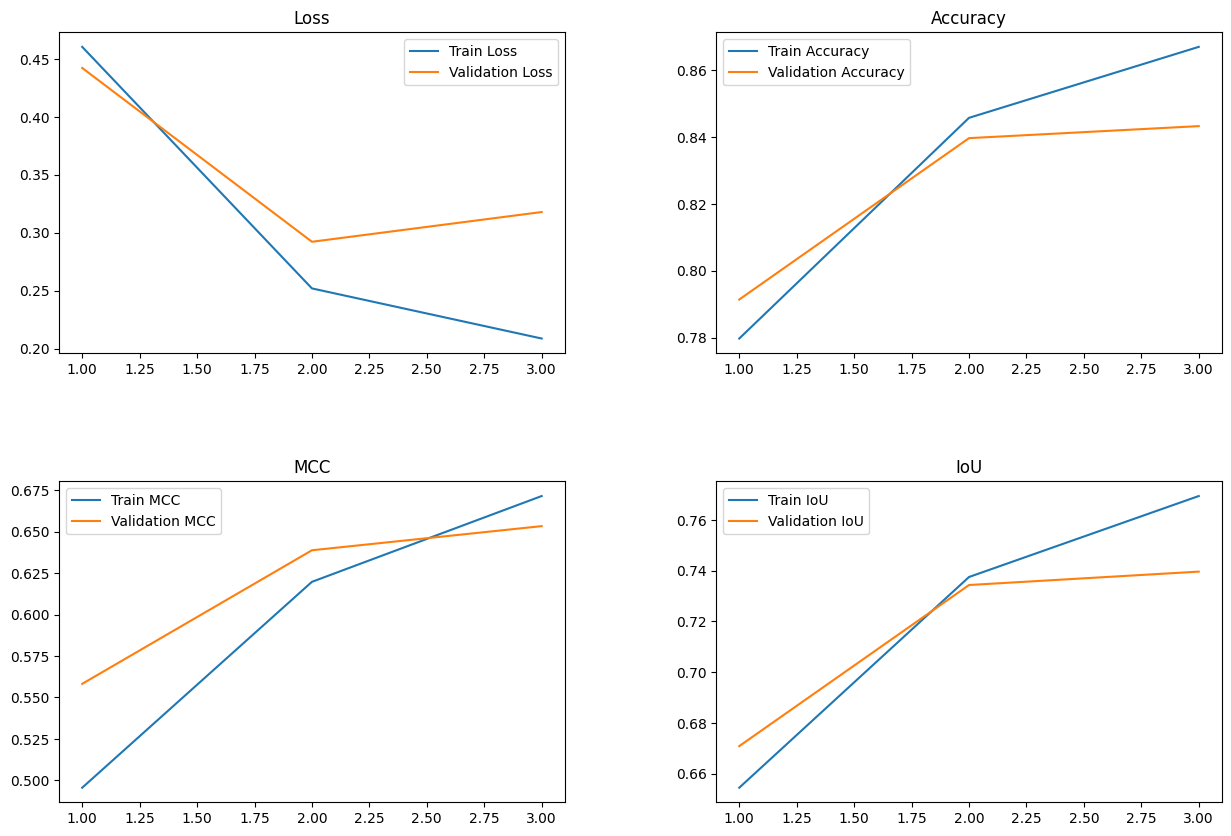

In [42]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

ax[0, 0].plot(np.arange(1, EPOCHS + 1), train_loss, label='Train Loss')
ax[0, 0].plot(np.arange(1, EPOCHS + 1), valid_loss, label='Validation Loss')
ax[0, 0].set_title('Loss')
ax[0, 0].legend()

ax[0, 1].plot(np.arange(1, EPOCHS + 1), train_accuracy, label='Train Accuracy')
ax[0, 1].plot(np.arange(1, EPOCHS + 1), valid_accuracy, label='Validation Accuracy')
ax[0, 1].set_title('Accuracy')
ax[0, 1].legend()

ax[1, 0].plot(np.arange(1, EPOCHS + 1), train_mcc, label='Train MCC')
ax[1, 0].plot(np.arange(1, EPOCHS + 1), valid_mcc, label='Validation MCC')
ax[1, 0].set_title('MCC')
ax[1, 0].legend()

ax[1, 1].plot(np.arange(1, EPOCHS + 1), train_iou, label='Train IoU')
ax[1, 1].plot(np.arange(1, EPOCHS + 1), valid_iou, label='Validation IoU')
ax[1, 1].set_title('IoU')
ax[1, 1].legend()

plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()

In [145]:
torch.save(seg_model, "full_segmentation_model_2.pth")

In [146]:
torch.save(seg_model.state_dict(), "segmentation_model_2.pth")

In [43]:
import gc
import torch

# Clear unnecessary variables
gc.collect()
torch.cuda.empty_cache()

In [46]:
seg_model.eval()

NUM_TEST_POINTS = 16384

test_dataset = GOOSEDataset(
    x_path=x_val_path, 
    y_path=y_val_path, 
    num_points=NUM_TEST_POINTS, 
)

test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

from tqdm import tqdm

# Inicializar listas
points_list = []
labels_list = []
preds_list = []

with torch.no_grad():
    for i, (points, targets) in tqdm(enumerate(test_loader), total=len(test_loader)):
        # points: (B, N, 3)
        # targets: (B, N)
        points = points.to(DEVICE)                  # (B, N, 3)
        targets = targets.to(DEVICE)                # (B, N)
        input_points = points.transpose(2, 1)       # (B, 3, N)

        preds, _, _ = seg_model(input_points)
        pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)  # (B, N)

        for b in range(points.shape[0]):
            points_list.append(points[b].cpu().numpy())          # (N, 3)
            labels_list.append(targets[b].cpu().numpy())         # (N,)
            preds_list.append(pred_choice[b].cpu().numpy())      # (N,)

points_list = np.array(points_list)
labels_list = np.array(labels_list)
preds_list = np.array(preds_list)

Procesando nubes de puntos:  55%|█████▌    | 531/961 [01:34<00:27, 15.84it/s]

 Descartando nube con 14147 puntos (menor a 16384)
 Descartando nube con 14449 puntos (menor a 16384)


Procesando nubes de puntos:  56%|█████▌    | 537/961 [01:34<00:20, 20.23it/s]

 Descartando nube con 10055 puntos (menor a 16384)


Procesando nubes de puntos:  95%|█████████▌| 914/961 [02:43<00:03, 13.41it/s]

 Descartando nube con 13018 puntos (menor a 16384)
 Descartando nube con 14846 puntos (menor a 16384)


100%|██████████| 1562/1562 [00:37<00:00, 42.04it/s]


In [47]:
points_list.shape, labels_list.shape, preds_list.shape

((6246, 16384, 3), (6246, 16384), (6246, 16384))

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define color map for 3 categories
color_map = {
    0: 'limegreen',  # Drivable (Green for clear zones)
    1: 'red',        # Obstacle (Red for danger/obstacles)
    2: 'gray'        # Void (Gray for undefined points)
}

# Function to plot the confusion matrix in percentage
def plot_confusion_matrix_percentage(y_val, predicted_labels, num_classes=3):
    y_true = y_val.flatten()
    y_pred = predicted_labels.flatten()

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))
    
    # Convert to percentage
    cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
    cm_percentage = np.nan_to_num(cm_percentage)  # Avoid NaNs due to division by zero

    # Class labels for the new categorization
    class_labels = {
        0: "Drivable",
        1: "Obstacle",
        2: "Void"
    }
    
    class_names = [class_labels[i] for i in range(num_classes)]

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names,
                vmin=0, vmax=100)

    plt.xlabel("Clases Predichas")
    plt.ylabel("Clases Reales")
    plt.title("Matriz de Confusión en Porcentaje")
    plt.show()

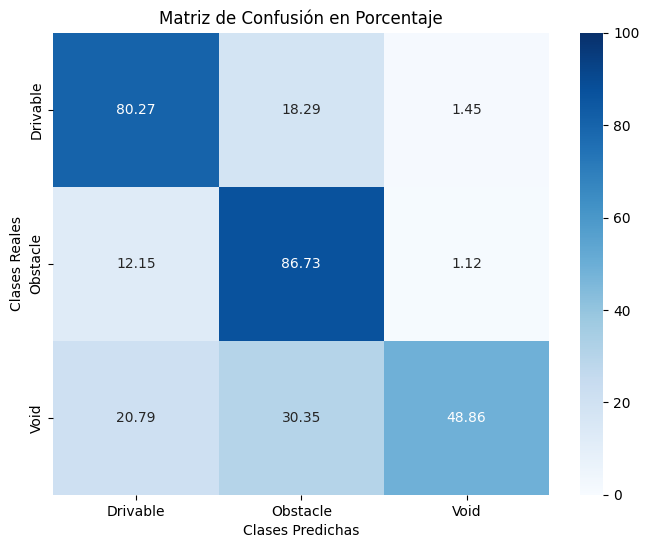

In [49]:
plot_confusion_matrix_percentage(labels_list, preds_list, num_classes=3)

In [50]:
import plotly.graph_objects as go
import numpy as np

# Diccionario de clases de segmentación con las etiquetas reducidas a 3 categorías
class_labels = {
    0: "Drivable",  # Zona transitable
    1: "Obstacle",  # Obstáculos
    2: "Void"       # Puntos sin etiqueta
}

# Asignación de colores para las 3 clases
color_mapping = {
    0: "limegreen",  # Drivable
    1: "red",        # Obstacle
    2: "dimgray"     # Void
}

def visualizar_comparacion_segmentacion(x_val, y_val, predicted_labels, indice):
    if indice >= len(x_val):
        print(f"Índice fuera de rango. Debe estar entre 0 y {len(x_val)-1}.")
        return

    # Extraer la nube de puntos y las etiquetas correspondientes
    puntos = x_val[indice]
    etiquetas_reales = y_val[indice]
    etiquetas_predichas = predicted_labels[indice]

    # Crear figuras separadas
    fig_real = go.Figure()
    fig_pred = go.Figure()

    for class_id, class_name in class_labels.items():
        indices_real = np.where(etiquetas_reales == class_id)[0]
        indices_pred = np.where(etiquetas_predichas == class_id)[0]

        if len(indices_real) > 0:
            fig_real.add_trace(go.Scatter3d(
                x=puntos[indices_real, 0],
                y=puntos[indices_real, 1],
                z=puntos[indices_real, 2],
                mode='markers',
                marker=dict(
                    size=1.5,
                    color=color_mapping[class_id],
                    opacity=0.8
                ),
                name=f"[Real] {class_name}"
            ))

        if len(indices_pred) > 0:
            fig_pred.add_trace(go.Scatter3d(
                x=puntos[indices_pred, 0],
                y=puntos[indices_pred, 1],
                z=puntos[indices_pred, 2],
                mode='markers',
                marker=dict(
                    size=1.5,
                    color=color_mapping[class_id],
                    opacity=0.8
                ),
                name=f"[Predicho] {class_name}"
            ))

    # Configuración del gráfico de etiquetas reales
    fig_real.update_layout(
        title=f"Segmentación Real - Índice {indice}",
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z"
        ),
        legend_title="Clases de Segmentación"
    )

    # Configuración del gráfico de etiquetas predichas
    fig_pred.update_layout(
        title=f"Segmentación Predicha - Índice {indice}",
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z"
        ),
        legend_title="Clases de Segmentación"
    )

    # Mostrar ambas figuras
    fig_real.show()
    fig_pred.show()

In [62]:
visualizar_comparacion_segmentacion(points_list, labels_list, preds_list, indice=732)